## Objective
Identify which are the primary factors that influence medical expenses?
Train a model that can predict medical insurance cost?
Dataset: from Kaggle


In [768]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


In [769]:
df = pd.read_csv('medical_insurance.csv')
print(df.head())
print(df.info())
print(df.describe())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB
None
               age          bmi     children       charges
count  2772.000000  2772.000000

In [770]:
print(df['region'].value_counts())

region
southeast    766
southwest    684
northwest    664
northeast    658
Name: count, dtype: int64


## Data Processing

### Examine Target column: charges

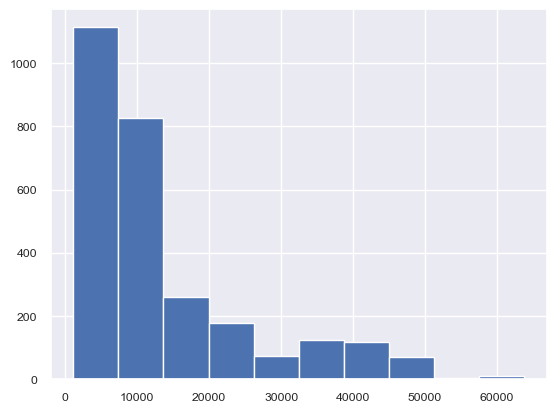

In [771]:
#explore target col
plt.hist(df['charges'])
plt.show()


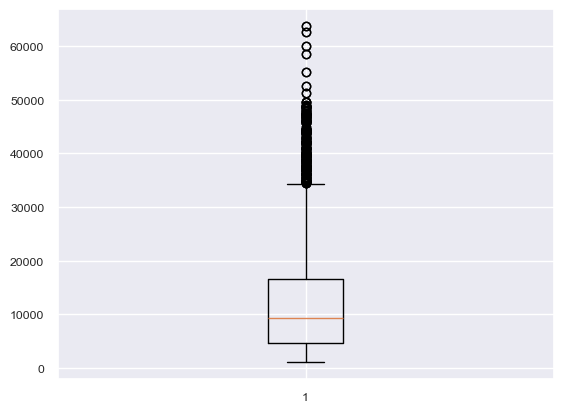

In [772]:
#detect outliers
plt.boxplot(df['charges'])
plt.show()

In [773]:
#Find quartiles
percentiles =[25,50,75]
quartiles=np.percentile(df['charges'],percentiles)
print(f"Quartiles: 25th, 50th, 70th: {quartiles}")
iqr = quartiles[2]-quartiles[0] 
print(f"IQR: {iqr}")


Quartiles: 25th, 50th, 70th: [ 4687.797    9333.01435 16577.7795 ]
IQR: 11889.982500000002


In [774]:
lower_bound = quartiles[0] - (1.5*iqr)
upper_bound = quartiles[2] + (1.5*iqr)
print(f"upper bound: {upper_bound}")
print(f"lower bound: {lower_bound}")

upper bound: 34412.75325000001
lower bound: -13147.176750000006


In [775]:
#total outliers for "charges"
num_outliers= sum((df['charges']<lower_bound)|(df['charges']>upper_bound))
print(f"total outliers: {num_outliers}")

lower_outliers = sum(df['charges']<lower_bound)
upper_outliers = sum(df['charges']>upper_bound)
print(f"ouliers count: {upper_outliers}, {lower_outliers}")

total outliers: 296
ouliers count: 296, 0


In [776]:
#replace outliers
new_df = df.copy()
new_df['charges']=np.where(new_df['charges']>upper_bound, upper_bound,df['charges'])
num_outliers2 = sum((new_df['charges']<lower_bound)|(new_df['charges']>upper_bound))
print(num_outliers2)

0


### Examine Feature columns

In [777]:
#Age group: 
#0: Early Young Adulthood (ages 18-21), 
#1: Late Young Adulthood (ages 22–34), 
#2: Early Middle Age (ages 35–44), 
#3: Late Middle Age (ages 45–64), 
#4: Late Adulthood (ages 65 and older).

new_df['age group']= 0
new_df['age group']=np.where((new_df['age']>21) & (new_df['age']<35),1,new_df['age group'])
new_df['age group']=np.where((new_df['age']>34) & (new_df['age']<45),2,new_df['age group'])
new_df['age group']=np.where((new_df['age']>44) & (new_df['age']<65),3,new_df['age group'])
new_df['age group']=np.where(new_df['age']>65, 4,new_df['age group'])
print(new_df['age group'].value_counts())


age group
3    1094
1     740
2     530
0     408
Name: count, dtype: int64


In [778]:
#BMI group: 
#0: Underweight (below 18.5), 
#1: Healthy Weight (18.5-24.9), 
#2: Overweight (25 - 29.9), 
#3: Obesity (30 and plus, 

new_df['bmi category']= 0
new_df['bmi category']=np.where((new_df['bmi']>=18.5) & (new_df['bmi']<25),1,new_df['bmi category'])
new_df['bmi category']=np.where((new_df['bmi']>=25) & (new_df['bmi']<29.9),2,new_df['bmi category'])
new_df['bmi category']=np.where(new_df['bmi']>=30,3,new_df['bmi category'])

print(new_df['bmi category'].value_counts())

bmi category
3    1470
2     766
1     472
0      64
Name: count, dtype: int64


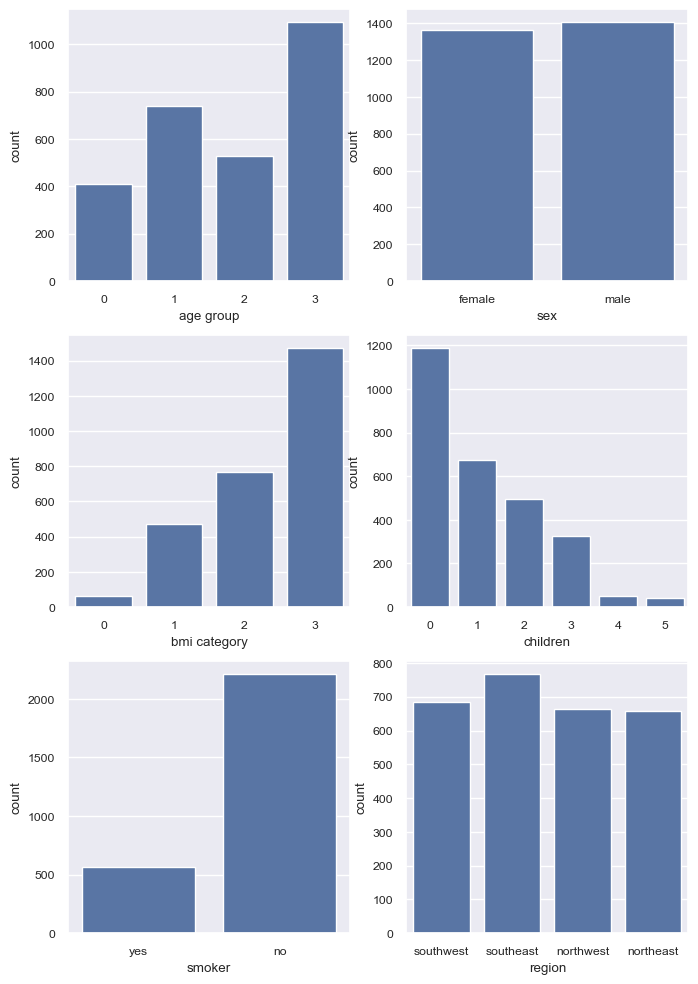

In [779]:
#Examine categorical cols
import seaborn as sns

col_list =['age group','sex','bmi category','children','smoker','region']
plt.figure(figsize=(8,12))
for n, i in zip(range(1,7),col_list):
    plt.subplot(3,2,n)
    sns.countplot(x=i,data = new_df)
plt.show()

In [780]:
#sex: M:0, F:1
new_df["sex"].replace({"male": 0, "female": 1}, inplace = True)
print(new_df['sex'].value_counts())
#smoker: yes: 1, no: 0
new_df["smoker"].replace({"yes": 1, "no": 0}, inplace = True)
print(new_df['smoker'].value_counts())

sex
0    1406
1    1366
Name: count, dtype: int64
smoker
0    2208
1     564
Name: count, dtype: int64


/var/folders/5w/1jc6c_9x2cz3y0xnbpsl91zr0000gn/T/ipykernel_62950/979782627.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_df["sex"].replace({"male": 0, "female": 1}, inplace = True)
/var/folders/5w/1jc6c_9x2cz3y0xnbpsl91zr0000gn/T/ipykernel_62950/979782627.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downc

In [781]:
new_df = pd.get_dummies(data=new_df, columns=['region'],drop_first=False)
print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               2772 non-null   int64  
 1   sex               2772 non-null   int64  
 2   bmi               2772 non-null   float64
 3   children          2772 non-null   int64  
 4   smoker            2772 non-null   int64  
 5   charges           2772 non-null   float64
 6   age group         2772 non-null   int64  
 7   bmi category      2772 non-null   int64  
 8   region_northeast  2772 non-null   bool   
 9   region_northwest  2772 non-null   bool   
 10  region_southeast  2772 non-null   bool   
 11  region_southwest  2772 non-null   bool   
dtypes: bool(4), float64(2), int64(6)
memory usage: 184.2 KB
None


In [782]:
print(new_df.describe())
print()

               age          sex          bmi     children       smoker  \
count  2772.000000  2772.000000  2772.000000  2772.000000  2772.000000   
mean     39.109668     0.492785    30.701349     1.101732     0.203463   
std      14.081459     0.500038     6.129449     1.214806     0.402647   
min      18.000000     0.000000    15.960000     0.000000     0.000000   
25%      26.000000     0.000000    26.220000     0.000000     0.000000   
50%      39.000000     0.000000    30.447500     1.000000     0.000000   
75%      51.000000     1.000000    34.770000     2.000000     0.000000   
max      64.000000     1.000000    53.130000     5.000000     1.000000   

            charges    age group  bmi category  
count   2772.000000  2772.000000   2772.000000  
mean   12455.464566     1.833333      2.313853  
std    10174.073271     1.105904      0.833472  
min     1121.873900     0.000000      0.000000  
25%     4687.797000     1.000000      2.000000  
50%     9333.014350     2.000000      3

In [783]:
data_corr = round(new_df.corr(),3)
print(data_corr)
#correlation (H-L): smoker, age/age group, bmi, children, sex,region_southwest. 

                    age    sex    bmi  children  smoker  charges  age group  \
age               1.000  0.026  0.113     0.038  -0.023    0.312      0.948   
sex               0.026  1.000 -0.043    -0.016  -0.082   -0.057      0.025   
bmi               0.113 -0.043  1.000    -0.001   0.011    0.161      0.104   
children          0.038 -0.016 -0.001     1.000   0.006    0.071      0.094   
smoker           -0.023 -0.082  0.011     0.006   1.000    0.786     -0.026   
charges           0.312 -0.057  0.161     0.071   0.786    1.000      0.292   
age group         0.948  0.025  0.104     0.094  -0.026    0.292      1.000   
bmi category      0.106 -0.051  0.826    -0.009  -0.001    0.162      0.093   
region_northeast  0.005 -0.000 -0.141    -0.023   0.004    0.022      0.012   
region_northwest -0.001  0.018 -0.142     0.030  -0.036   -0.031     -0.004   
region_southeast -0.015 -0.022  0.280    -0.031   0.072    0.059     -0.018   
region_southwest  0.012  0.005 -0.011     0.025  -0.

<function matplotlib.pyplot.ticklabel_format(*, axis: "Literal['both', 'x', 'y']" = 'both', style: "Literal['', 'sci', 'scientific', 'plain']" = '', scilimits: 'tuple[int, int] | None' = None, useOffset: 'bool | float | None' = None, useLocale: 'bool | None' = None, useMathText: 'bool | None' = None) -> 'None'>

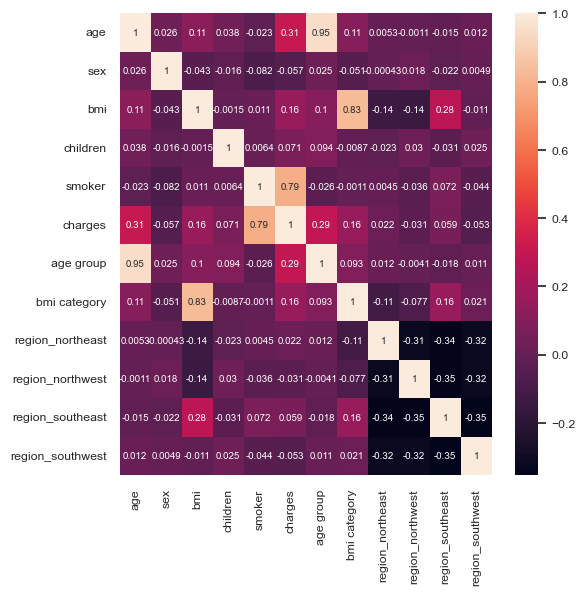

In [784]:
#correlation plot
plt.figure(figsize=(6,6))
sns.set(font_scale=0.8)
sns.heatmap(new_df[data_corr.index].corr(),annot=True, annot_kws={'size': 7})
plt.ticklabel_format

Summary:
- refined dataframe: new_df
- No missing values. 
- Outliers have been replaced with upper/lower bound
- target col: charges
- features: age group, sex, children, smoker, bmi cagegory, all regions

## Building model

In [785]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score

In [786]:
#prepare dataset 
#set 1: use the categorical values of age and bmi (age group, bmi category)
# R2 score: 72% - Linear regression
# R2 score: 79% - Decision Tree Regression (max depth=3)
# R2 score 81% - Decision Tree Regression with GridSearch 
#X = new_df.drop(['age','bmi','charges'],axis=1)
#y = new_df['charges']

#set 2: include continue values of age and bmi 
# R2 score: 72.8% - Linear regression
# R2 score: 80.79% - Decision Tree Regression (max depth=3)
# R2 score 80.5% - Decision Tree Regression with GridSearch 
X = new_df.drop(['age group','bmi category','charges'],axis=1)
y = new_df['charges']

print(X.columns)
X_data = X.copy()
print(X_data.info())

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               2772 non-null   int64  
 1   sex               2772 non-null   int64  
 2   bmi               2772 non-null   float64
 3   children          2772 non-null   int64  
 4   smoker            2772 non-null   int64  
 5   region_northeast  2772 non-null   bool   
 6   region_northwest  2772 non-null   bool   
 7   region_southeast  2772 non-null   bool   
 8   region_southwest  2772 non-null   bool   
dtypes: bool(4), float64(1), int64(4)
memory usage: 119.2 KB
None


In [787]:
#prepare the data for model
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.20,random_state=100)
print(X_train.shape)
print(X_test.shape)


(2217, 9)
(555, 9)


### Model 1: Linear Regression

In [788]:
#Model 1
linear = LinearRegression()
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
train_mse = mean_squared_error(y_train, linear.predict(X_train))
test_mse = mean_squared_error(y_test, y_pred)
print(f"train mse: {train_mse}")
print(f"test mse: {test_mse}")

train mse: 26080301.04278363
test mse: 27334719.9309082


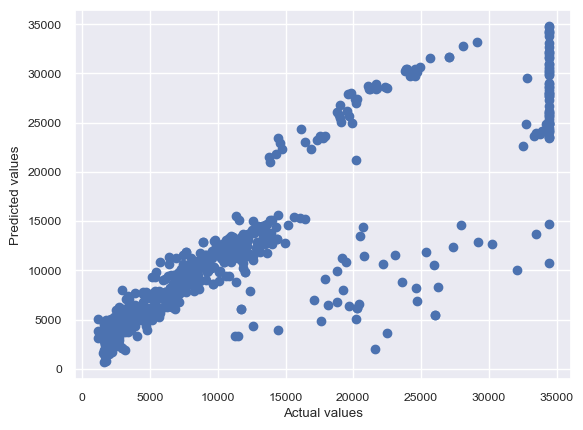

In [789]:
#graph predicted values and actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

In [790]:
#coefficient:
print(linear.coef_)
#Coefficient of determination
r2_test = r2_score(y_test, y_pred)
print(f"R2 score: {r2_test}")

[ 3.23898399e+03  1.17499996e+02  1.28120476e+03  4.68263024e+02
  8.04081795e+03 -2.00225820e+16 -2.00850994e+16 -2.10443003e+16
 -2.02884066e+16]
R2 score: 0.7282122737478613


### Decision Tree Regression

In [791]:
#Model 2: Decision Tree
from sklearn.tree import DecisionTreeRegressor

In [792]:
rg = DecisionTreeRegressor(max_depth=3)
rg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [793]:
rg.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [794]:
y_pred2 = rg.predict(X_test)
rg_mse = mean_squared_error(y_test, y_pred2)
print(f"Decision Tree Regerssion MSE: {rg_mse}")
print(f"R2 score: {r2_score(y_test,y_pred2)}")

Decision Tree Regerssion MSE: 19315857.496429566
R2 score: 0.8079434139865177


#Top correlated features:

In [795]:
#print(rg.feature_importances_)

In [796]:
features = pd.DataFrame(rg.feature_importances_, X_save.columns)
print(features)
#smoker, bmi, age

                         0
sex               0.140824
children          0.000000
smoker            0.102818
age group         0.000000
bmi category      0.756358
region_northeast  0.000000
region_northwest  0.000000
region_southeast  0.000000
region_southwest  0.000000


In [797]:
# from sklearn.tree import plot_tree

# plt.figure(figsize = (12.0, 8.0)) # Setting the size of displayed Tree

# plot_tree(rg, 
#     feature_names = X.column, 
#     filled = True,       
#     proportion = True,
#     precision = 0,
#     rounded = True,
#     fontsize = 11)

# plt.show()

### Tunning - Optimizer parameters

### Complexity Pruning

In [798]:
#find optimal alpha - with cost_complexity_pruning_path

cost_path = rg.cost_complexity_pruning_path(X_train,y_train)

ccp_alphas, impurities = cost_path.ccp_alphas, cost_path.impurities

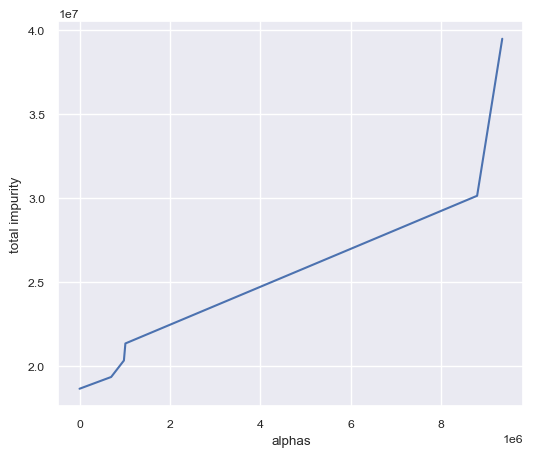

In [799]:
plt.figure(figsize=(6,5))
plt.plot(ccp_alphas[:-1],impurities[:-1])
plt.xlabel("alphas")
plt.ylabel("total impurity")
plt.show()

In [800]:
subtrees =[]
for alpha in cost_path.ccp_alphas:
    subtree = DecisionTreeRegressor(random_state=100, ccp_alpha=alpha)
    subtree.fit(X_train,y_train)
    subtrees.append(subtree)

print(subtrees)

[DecisionTreeRegressor(random_state=100), DecisionTreeRegressor(ccp_alpha=911.8590428314074, random_state=100), DecisionTreeRegressor(ccp_alpha=699986.9729873985, random_state=100), DecisionTreeRegressor(ccp_alpha=981873.3895104751, random_state=100), DecisionTreeRegressor(ccp_alpha=1014423.2439048886, random_state=100), DecisionTreeRegressor(ccp_alpha=8794917.127377477, random_state=100), DecisionTreeRegressor(ccp_alpha=9350904.045435723, random_state=100), DecisionTreeRegressor(ccp_alpha=64704821.556723624, random_state=100)]


In [801]:
#Find the score for the subtree slide
ccp_alphas_slice = cost_path.ccp_alphas[-10:-3]
subtree_slide = subtrees[-10:-3]
subtree_scores = [subtree.score(X_test,y_test) for subtree in subtree_slide]

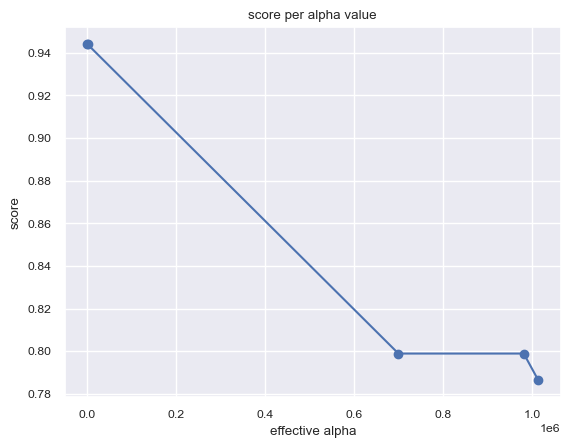

In [802]:
plt.plot(ccp_alphas_slice, subtree_scores, marker="o")
plt.xlabel("effective alpha")
plt.ylabel("score")
plt.title("score per alpha value")
plt.show()

In [803]:
alpha_scores = tuple(zip(ccp_alphas_slice, subtree_scores))
print(f"alpha score: {alpha_scores}")

#Find the highest score in this slice. Round to the 4 decimals)
max_alpha_score = max(alpha_scores, key=lambda x: x[1])
print(f"highest score: {max_alpha_score}")

alpha score: ((0.0, 0.9441061764733581), (911.8590428314074, 0.9439162814591842), (699986.9729873985, 0.7989964654223847), (981873.3895104751, 0.7989964654223847), (1014423.2439048886, 0.7865662669451151))
highest score: (0.0, 0.9441061764733581)


#### Cross Validation

In [804]:
from sklearn.model_selection import cross_validate

In [805]:
multi_scores = cross_validate(
    rg, X,y,cv=5,
    scoring=("neg_mean_absolute_error","neg_mean_squared_error")
)
print(multi_scores)

{'fit_time': array([0.00212312, 0.0015099 , 0.00127578, 0.00123215, 0.00122714]), 'score_time': array([0.00054502, 0.00053596, 0.00038195, 0.00035691, 0.00034189]), 'test_neg_mean_absolute_error': array([-2570.34574224, -2306.49458607, -2413.31088935, -2412.60814436,
       -2459.43513326]), 'test_neg_mean_squared_error': array([-20761200.10473846, -16999610.69564283, -17871122.6983491 ,
       -19293572.52040228, -19544817.11941   ])}


In [806]:
#find the mean of mae and mse
mean_cv_mse = multi_scores['test_neg_mean_squared_error'].mean()
mean_cv_mae = multi_scores['test_neg_mean_absolute_error'].mean()
print("Mean of MSE: "+ str(mean_cv_mse))
print("Mean of MAE: "+ str(mean_cv_mae))

Mean of MSE: -18894064.627708532
Mean of MAE: -2432.438899055158


### Gridsearch CV

In [807]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [808]:
parameters = {
    "criterion": ["squared_error","absolute_error"],
    "min_samples_split":[12,15,20,50],
    "max_depth":[3,4,5],
    "min_samples_leaf":[5,8,10,]
}

reg_tree = DecisionTreeRegressor(random_state=100)
grid = GridSearchCV(reg_tree, param_grid=parameters,
                    scoring="neg_mean_absolute_error",n_jobs=1)

grid.fit(X,y)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=100), n_jobs=1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [5, 8, 10],
                         'min_samples_split': [12, 15, 20, 50]},
             scoring='neg_mean_absolute_error')

In [809]:
best_params = grid.best_params_
best_score = grid.best_score_
best_estimator = grid.best_estimator_

print("Best attributes from GridSearch CV")
print(f"best parameters: {best_params}")
print(f"best score: {best_score}")
print(f"best estimator: {best_params}")

Best attributes from GridSearch CV
best parameters: {'criterion': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 12}
best score: -1649.124687339663
best estimator: {'criterion': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 12}


In [810]:
dtr = DecisionTreeRegressor(criterion= 'absolute_error',max_depth= 5, min_samples_leaf= 5, min_samples_split= 12,random_state=100)
dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'absolute_error',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 100,
 'splitter': 'best'}

In [811]:
dtr.fit(X_train,y_train)
y_pred = dtr.predict(X_test)
print(f"MSE score: {mean_squared_error(y_test, y_pred)}")
print(f"MAE score: {mean_absolute_error(y_test, y_pred)}")
print(f"R2 socre: {r2_score(y_test, y_pred)}")

MSE score: 19519358.840047393
MAE score: 1733.1360569909912
R2 socre: 0.8059200105051232


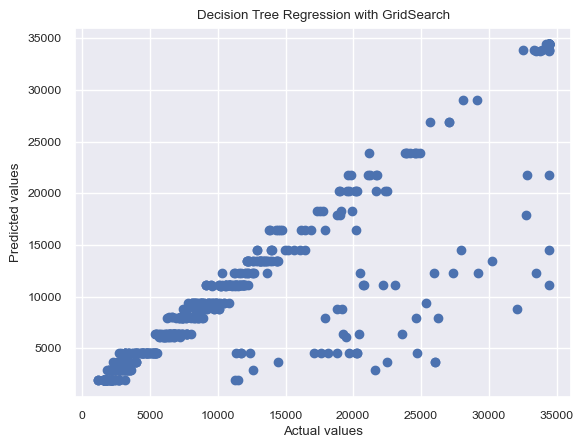

In [812]:
#graph predicted values and actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title("Decision Tree Regression with GridSearch")
plt.show()

In [814]:
from sklearn.tree import export_text
exported_reg_tree = export_text(dtr, feature_names=X_data.columns)
print(exported_reg_tree)

|--- smoker <= 0.74
|   |--- age <= 0.24
|   |   |--- age <= -0.82
|   |   |   |--- children <= 0.33
|   |   |   |   |--- age <= -1.18
|   |   |   |   |   |--- value: [1880.28]
|   |   |   |   |--- age >  -1.18
|   |   |   |   |   |--- value: [2904.09]
|   |   |   |--- children >  0.33
|   |   |   |   |--- children <= 1.15
|   |   |   |   |   |--- value: [3636.63]
|   |   |   |   |--- children >  1.15
|   |   |   |   |   |--- value: [4504.66]
|   |   |--- age >  -0.82
|   |   |   |--- age <= -0.19
|   |   |   |   |--- children <= 1.15
|   |   |   |   |   |--- value: [4562.84]
|   |   |   |   |--- children >  1.15
|   |   |   |   |   |--- value: [6059.17]
|   |   |   |--- age >  -0.19
|   |   |   |   |--- children <= 1.15
|   |   |   |   |   |--- value: [6406.41]
|   |   |   |   |--- children >  1.15
|   |   |   |   |   |--- value: [7985.81]
|   |--- age >  0.24
|   |   |--- age <= 0.88
|   |   |   |--- age <= 0.60
|   |   |   |   |--- children <= 0.33
|   |   |   |   |   |--- value: [7

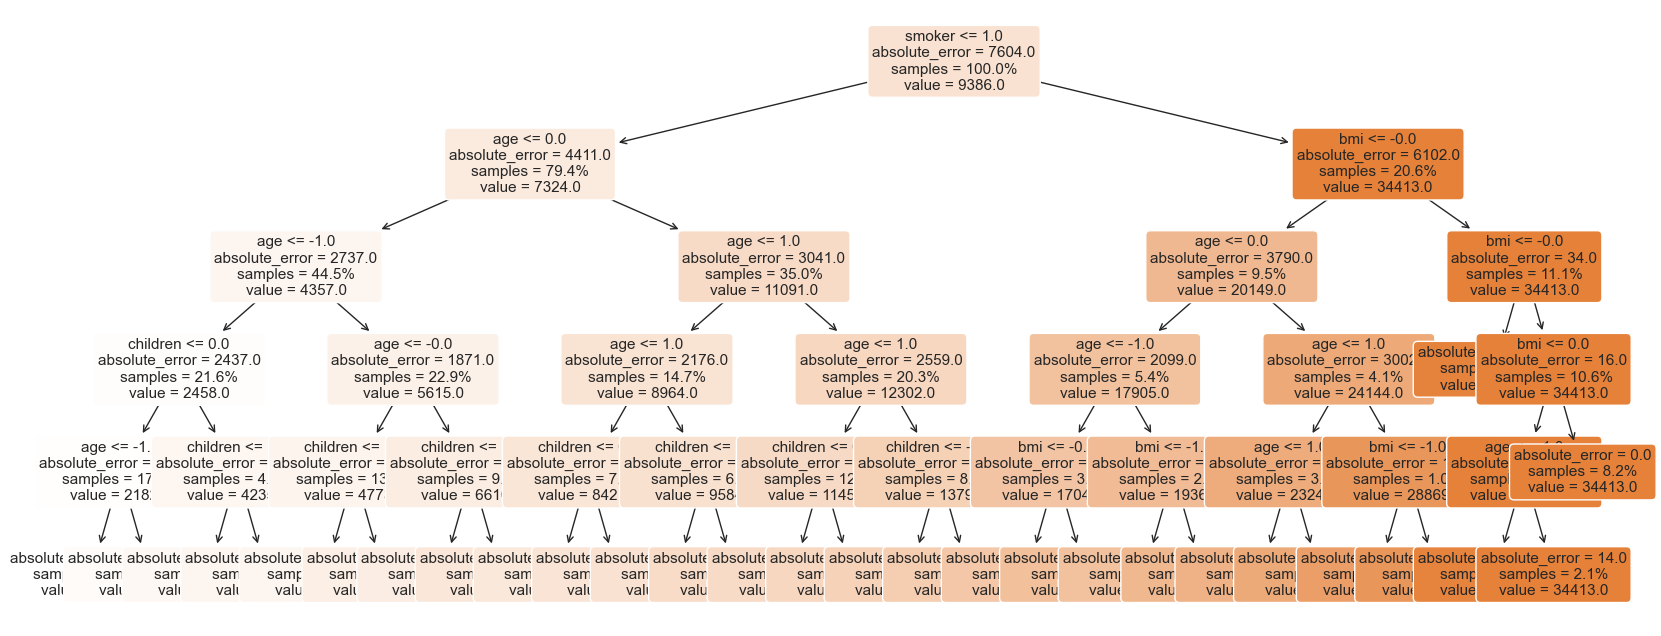

In [815]:
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

plt.figure(figsize = [20.0, 8.0]) # Setting the size of displayed Tree

plot_tree(dtr, 
    feature_names = X_data.columns, 
    filled = True,       
    proportion = True,
    precision = 0,
    rounded = True,
    fontsize = 11)

plt.show()